In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from permetrics.regression import RegressionMetric
import os
from copy import deepcopy

from reaverage import group_by_hour_range
from statistics_modules import correlation

In [2]:
first_timestamp = '2024-04-01 00:00:00'
last_timestamp = '2024-04-28 23:00:00'

#data prep
b21_data = pd.read_csv('files/B21_04_2024.csv')
embassy_sensor_data = pd.read_csv('files/Astana_PM2.5_2024_04.csv')

#time_difference = pd.Timedelta(hours=6)
b21_data['Timestamp'] = pd.to_datetime(b21_data['Timestamp'])
embassy_sensor_data['Date (LT)'] = pd.to_datetime(embassy_sensor_data['Date (LT)']) 

b21_data = b21_data.set_index('Timestamp')
embassy_sensor_data = embassy_sensor_data.set_index('Date (LT)')

b21_data['PM 2.5'] = b21_data['PM 2.5']*b21_data['Applied PM 2.5 Custom Calibration Setting - Multiplication Factor']

b21_data = b21_data.shift(+6)

#date range
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='1H')

b21_data = b21_data[start:end]
embassy_sensor_data = embassy_sensor_data[start:end]

b21_pm25 = b21_data['PM 2.5']
embassy_sensor_pm25 = embassy_sensor_data['Raw Conc.']


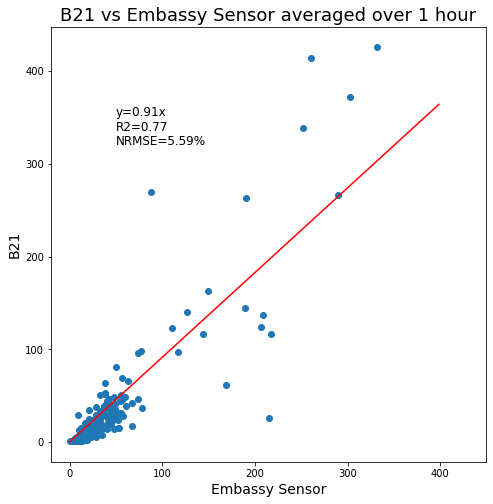

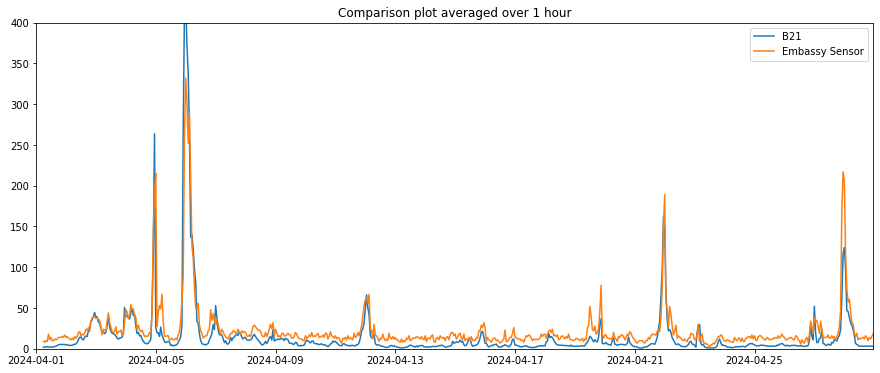

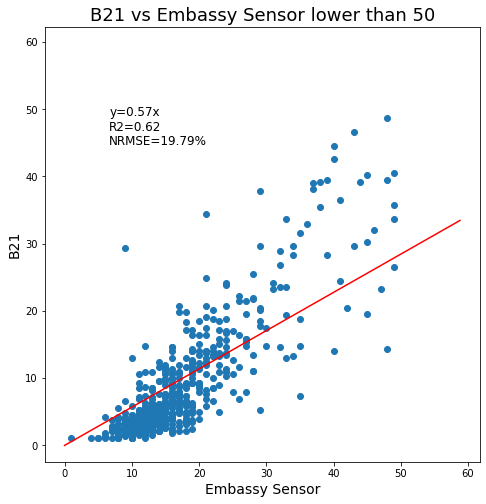

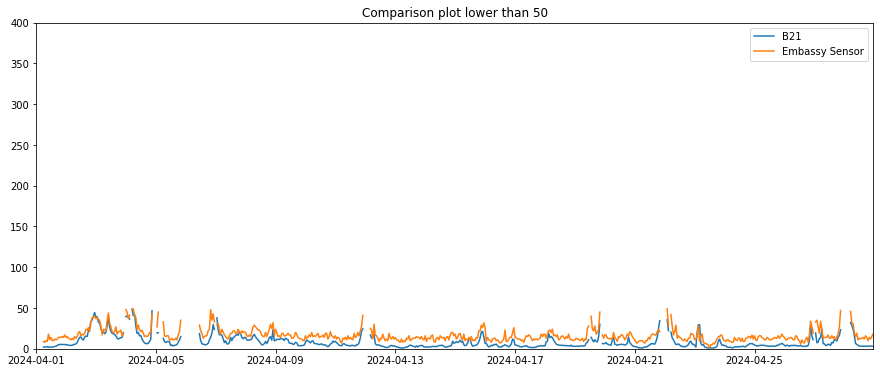

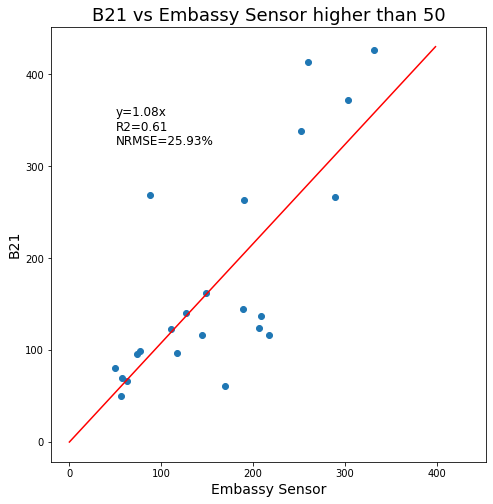

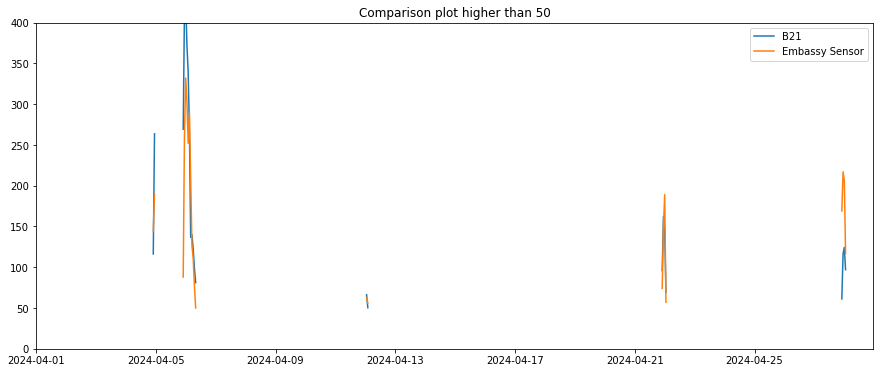

In [3]:
#fitting
def func(x, a, b):
    return a*x + b

def compare(x, y, cut, label = '', comparison_plot=True):

    x[~cut] = np.nan
    y[~cut] = np.nan #needed for time graphs

    popt, pcov = curve_fit(func, x[cut], y[cut], bounds=([-np.inf, -0.000001], [np.inf, 0.000001]))

    x_pp = np.linspace(0,np.max(x[cut])*1.2, 50)
    figure = plt.figure(figsize=(10, 8))
    plt.scatter(x[cut], y[cut])
    plt.plot(x_pp, func(x_pp, *popt), color='red')
    plt.ylabel('B21', fontsize=14)
    plt.xlabel('Embassy Sensor', fontsize=14)
    plt.axis('square')

    #r2 value
    residuals = y[cut] - func(x[cut], *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y[cut]-np.mean(y[cut]))**2)
    r_squared = 1 - (ss_res / ss_tot)
    r2_value = r_squared.round(2)

    #nrmse
    evaluator = RegressionMetric(x[cut], y[cut])
    nrmse = evaluator.normalized_root_mean_square_error(model=2)*100

    plt.text(0.3, 0.725, f"y={popt[0].round(2)}x", transform=figure.transFigure, fontsize=12)
    plt.text(0.3, 0.7, f"R2={r2_value}", transform=figure.transFigure, fontsize=12)
    plt.text(0.3, 0.675, f"NRMSE={nrmse.round(2)}%", transform=figure.transFigure, fontsize=12)
    plt.title(f'B21 vs Embassy Sensor {label}', fontsize=18)
    plt.savefig(f'graphs/B21_vs_embassy_sensor_fitting_{label}.png')

    if comparison_plot:
        #plotting
        plt.figure(figsize=(15, 6))
        plt.plot(dates, y, label='B21')
        plt.plot(dates, x, label='Embassy Sensor')
        plt.legend()
        plt.ylim(0, 400)
        plt.xlim(start, end)
        plt.title(f'Comparison plot {label}')
        plt.savefig(f'graphs/Comparison_plot{label}.png')

#turning to array and back because of reference copy procedure of python
x_ = np.array(deepcopy(embassy_sensor_pm25.values.tolist()))
y_ = np.array(deepcopy(b21_pm25.values.tolist()))

#all
cut1 = x_ >= 0; cut2 = y_ >= 0; cut = cut1 & cut2
compare(x_, y_, cut, label='averaged over 1 hour')

#lower than 50
cut1 = x_ < 50; cut2 = y_ < 50; cut = cut1 & cut2
compare(x_, y_, cut, label='lower than 50')

x_ = np.array(deepcopy(embassy_sensor_pm25.values.tolist()))
y_ = np.array(deepcopy(b21_pm25.values.tolist()))

#higher than 50
cut1 = x_ >= 50; cut2 = y_ >= 50; cut = cut1 & cut2
compare(x_, y_, cut, label='higher than 50')

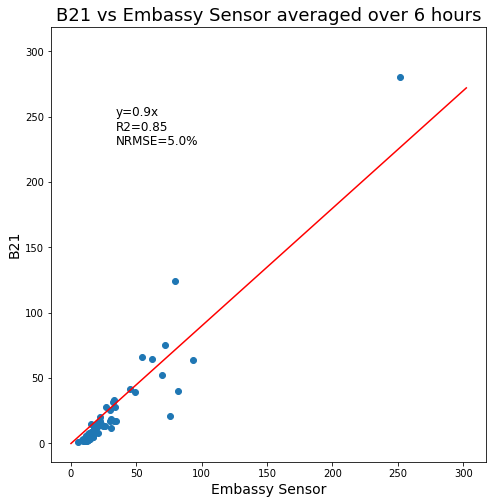

In [14]:
# do that with different average intervals

embassy_sensor_data['hour_indices'] = None
b21_data['hour_indices'] = None

range_length = 6
group_by_hour_range(embassy_sensor_data['hour_indices'].values, range_length=range_length)
group_by_hour_range(b21_data['hour_indices'].values, range_length=range_length) 

b21_averaged = b21_data.groupby('hour_indices').mean()
embassy_sensor_averaged = embassy_sensor_data.groupby('hour_indices').mean()

x_ = np.array(deepcopy(embassy_sensor_averaged['Raw Conc.'].values.tolist()))
y_ = np.array(deepcopy(b21_averaged['PM 2.5'].values.tolist()))

#all
cut1 = x_ >= 0; cut2 = y_ >= 0; cut = cut1 & cut2
compare(x_, y_, cut, comparison_plot=False, label=f'averaged over {range_length} hours')

#correct nrmse

In [31]:
frr = pd.DataFrame({
    'Timestamp' : dates,
    'embassy_sensor' : embassy_sensor_data['Raw Conc.'].values,
    'B21' : b21_data['PM 2.5'].values
})

frr.to_csv('pm25_vals.csv')